In [159]:
import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

In [3]:
n = pypsa.Network("networks/elec_s_100_ec_lcopt_Co2L-1H.nc")

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [18]:
days = pd.interval_range(start=n.snapshots[0], end=n.snapshots[-1] + pd.Timedelta('1 days'), freq='1D', closed='left')
snapshots_by_days = {i: [] for i in days}
day_iter = iter(snapshots_by_days)
current_day = next(day_iter)
for s in n.snapshots:
    if s not in current_day:
        current_day = next(day_iter)
    snapshots_by_days[current_day].append(s)

In [101]:
# We want to cluster daily series. So we need to transform a collection of yearly time series and shuffles the data around to get an array of shape (#days, 24 x #series).
def hourly_to_daily(series):
    a = series.to_numpy()
    old_shape = a.shape
    new_shape = (int(old_shape[0] / 24), old_shape[1] * 24)
    return a.reshape(new_shape)

In [222]:
def daily_series_distances(year_series: pd.DataFrame):
    """Output a distance matrix for the given time series.
    
    Specifically, output a 365 x 365 distance matrix giving the Euclidean distance between all the days in the input time series."""
    day_series = []
    for day in days:
        s = year_series.loc[snapshots_by_days[day]]
        s = s.reset_index().drop('snapshot', axis=1)
        s = s.to_numpy()
        day_series.append(s)
    distances = np.zeros(shape=(len(days), len(days)))
    for i in range(len(days)):
        for j in range(i):
            distances[i, j] = abs((day_series[i] - day_series[j]).sum().sum())
            distances[j, i] = distances[i, j]
    return distances


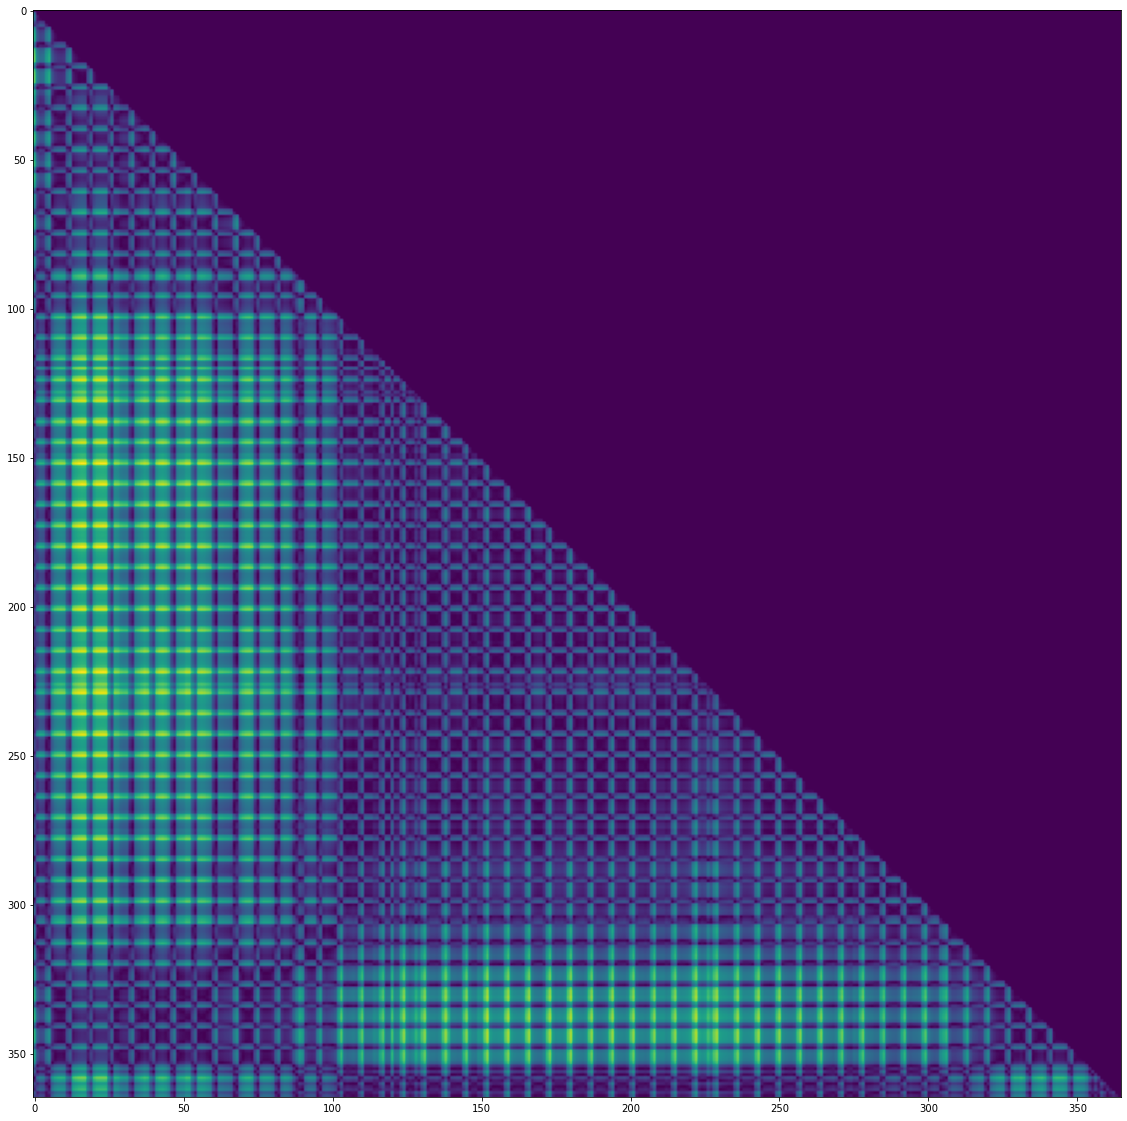

In [60]:
D = daily_series_distances(n.loads_t['p_set'])
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(D)

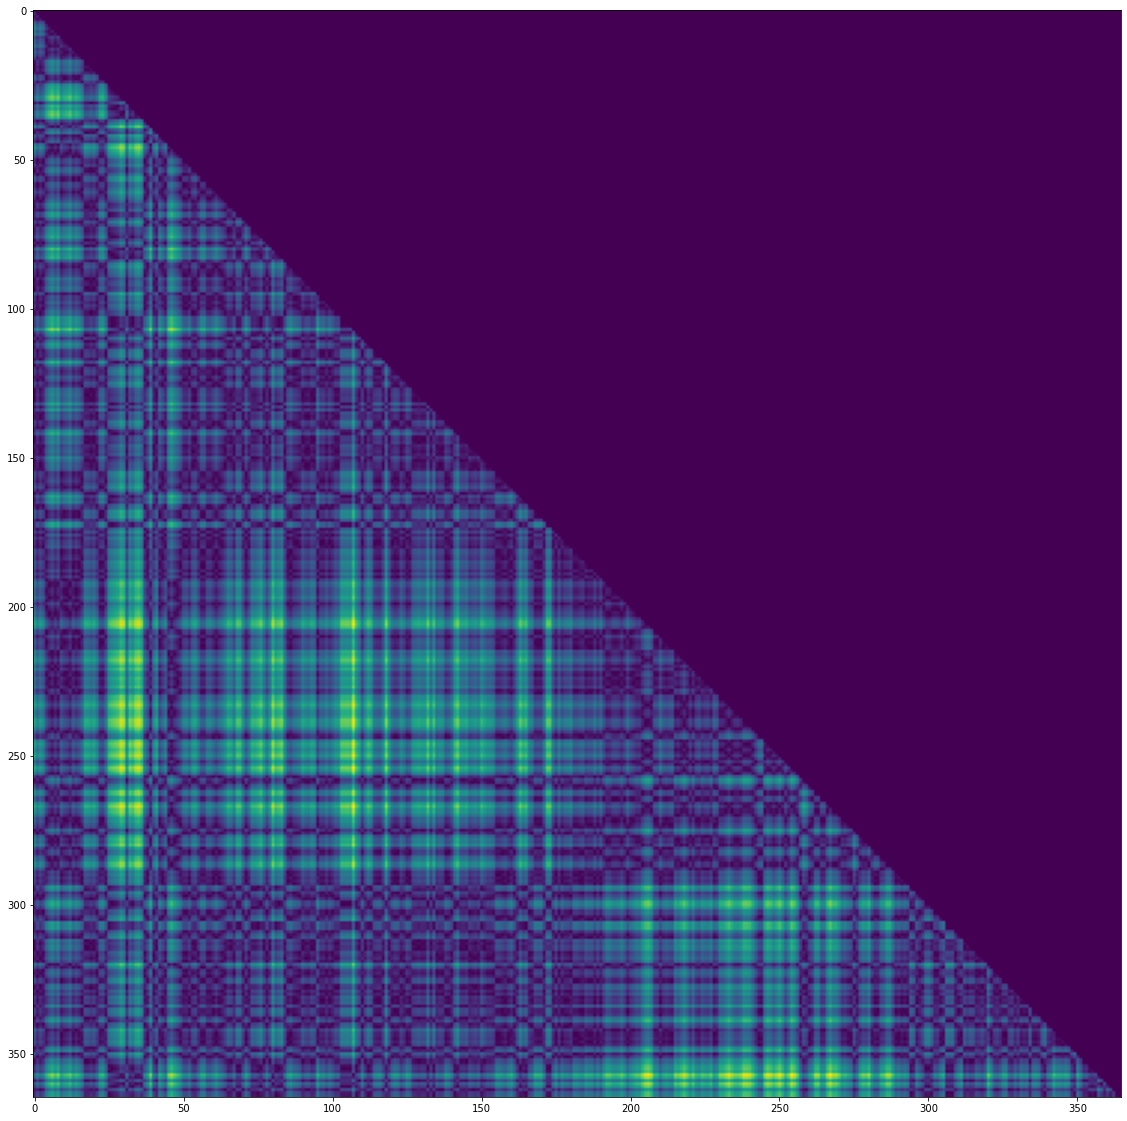

In [61]:
D = daily_series_distances(n.generators_t['p_max_pu'])
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(D)

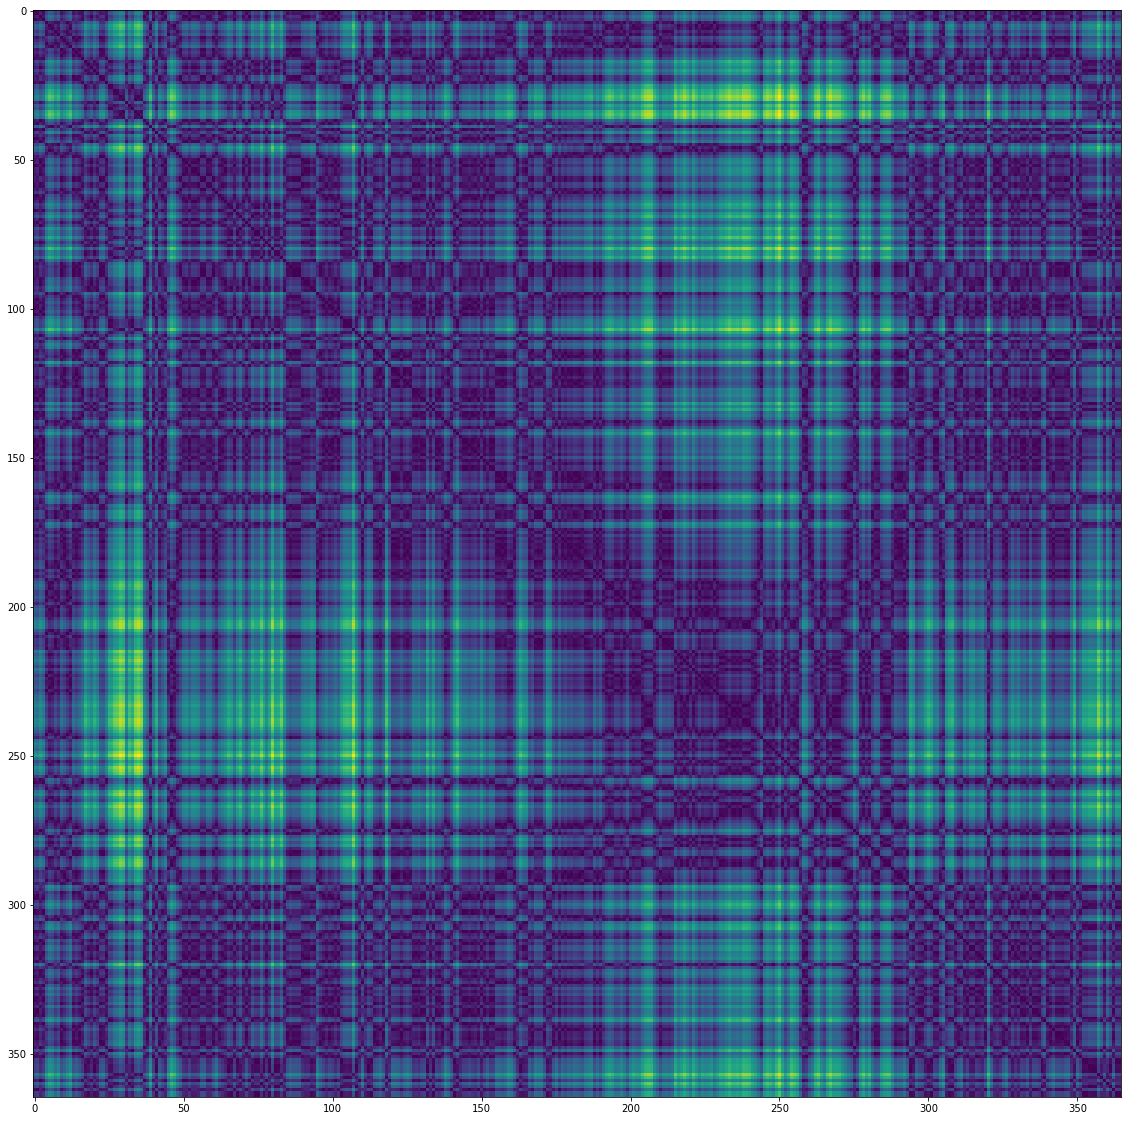

In [223]:
# Normalise loads column(node)-wise.
load_norm = n.loads_t['p_set'] / n.loads_t['p_set'].max()
# Normalise generation capacity factors.
cap_norm = n.generators_t['p_max_pu'] / n.generators_t['p_max_pu'].max()
# Create dataframe of both renewable capacity factor time series and load combined.
profile = pd.concat([cap_norm, load_norm], axis=1)
# Plot the distances between the daily profiles.
D = daily_series_distances(profile)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(D, interpolation='none')
fig.savefig("distances.pdf")

In [75]:
G = nx.convert_matrix.from_numpy_matrix(D + D.T)

In [129]:
norm_gen = n.generators_t['p_max_pu'] / n.generators_t['p_max_pu'].max()
norm_gen_days = hourly_to_daily(norm_gen)

In [130]:
norm_load = n.loads_t['p_set'] / n.loads_t['p_set'].max()
norm_load_days = hourly_to_daily(norm_load)

In [133]:
norm_profile_days = np.concatenate([norm_gen_days, norm_load_days], axis=1)

In [184]:
gen_no = n.generators_t['p_max_pu'].filter(regex='NO', axis=1)
norm_gen_no = gen_no / gen_no.max()
norm_gen_days_no = hourly_to_daily(norm_gen_no)

In [185]:
load_no = n.loads_t['p_set'].filter(regex='NO', axis=1)
norm_load_no = load_no / load_no.max()
norm_load_days_no = hourly_to_daily(norm_load_no)

In [186]:
cluster_numbers = [1] + [15 * i for i in range(1, 25)] + [365]
inertias = pd.DataFrame(columns=['Load NO', 'Generation NO', 'Load EUR', 'Load + Generation EUR'], index=cluster_numbers)
for c in cluster_numbers:
    inertias.loc[c, 'Load NO'] = KMeans(n_clusters=c, random_state=0).fit(norm_load_days_no).inertia_
    inertias.loc[c, 'Generation NO'] = KMeans(n_clusters=c, random_state=0).fit(norm_gen_days_no).inertia_
    inertias.loc[c, 'Load EUR'] = KMeans(n_clusters=c, random_state=0).fit(norm_load_days).inertia_
    inertias.loc[c, 'Load + Generation EUR'] = KMeans(n_clusters=c, random_state=0).fit(norm_profile_days).inertia_

# Note: there is very very little different between how well full data and just generation data clusters. So we just do full.

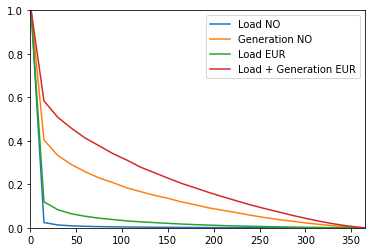

In [193]:
norm_inertias = inertias / inertias.max()
fig, ax = plt.subplots(figsize=(6, 4))
norm_inertias.plot(ax=ax)
ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=0, right=365)
fig.savefig("cluster_inertia_convergence.pdf")

In [200]:
len(['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK'])

33

In [217]:
len(n.generators_t['p_max_pu'].columns) + 33

405

In [171]:
# Note: projecting to a lower dimension using principle component analysis doesn't change anything: we get basically the same figure.
cs = 300
cluster_numbers = [1] + [15 * i for i in range(1, 25)] + [365]
inertias_pca = pd.DataFrame(columns=['Load', 'Generation', 'Full'], index=cluster_numbers)
for c in cluster_numbers:
    inertias_pca.loc[c, 'Load'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_load_days)).inertia_
    inertias_pca.loc[c, 'Generation'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_gen_days)).inertia_
    inertias_pca.loc[c, 'Full'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_profile_days)).inertia_

norm_inertias_pca = inertias_pca / inertias_pca.max()

fig, ax = plt.subplots(figsize=(10, 8))
norm_inertias_pca.plot(ax=ax)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=365)